In [1]:
using DifferentialEquations
using Plots
# plotlyjs() 

## Exercise 1.1.
A simplified $m$ longitudinal motion of an underwater vehicle can be described by
$$
m \ddot{x} + k \dot{x} |\dot{x}| = u
$$
where $x$ is position of the vehicle, $u$ is the control input (a force that is provided by a propeller), $m$ is the mass of the vehicle, and $k>0$ is the drag coefficient. Assuming the value of $m$ is known exactly, the drag coefficient is bounded $k_1 \leq k \leq k_2$ and the position and its derivative (velocity) $x, \dot{x}$ are measured:

1. Obtain a state system model of the vehicle using $x_1 = x, x_2 = \dot{x}$ as the state variables.
2. Design a conventional sliding mode control law $u$ that drives $x_1, x_2 \rightarrow 0$ as time increases.
3. Simulate the control system for $x_1(0) = 2$m, $x_2(0) = 0.5$m/s, $m = 4$kg, and $k=1.5+0.4 \sin (2t) \text{[kg/ms]}$. Plot the time histories of the sliding variable, the control function $u$, the position $x_1$, and the velocity $x_2$.
4. Identify the quantities that reach zero in finite time and the ones that approach zero asymptotically.

Hint: The function $k\dot{x}|\dot{x}|$ can be bounded as $|k\dot{x}|\dot{x}||\leq k_2 \dot{x}^2 = 1.9 \dot{x}^2$.

### Sol.
1. $$\begin{aligned}
\begin{array}{l}
\dot{x_1} = x_2 \\
\dot{x_2} = \dfrac{1}{m}\left( -kx_2 |x_2| + u \right)
\end{array}
\end{aligned}
$$
2. Let $$\sigma = x_2 + c x_1, \quad c>0,$$
   then $$\dot{\sigma} =  cx_2 + \frac{1}{m}\left(-kx_2|x_2| + u\right)$$
   let $$V = \frac{1}{2} \sigma ^2 \quad \Rightarrow \quad \dot{V} = \sigma \dot{\sigma} = \sigma \left( cx_2 + \frac{1}{m}\left(-kx_2|x_2| + u \right) \right)$$
   choose $$
       u = m(-cx_2 + v)
   $$
   then
   $$
   \dot{V} = \sigma \left( -\frac{k}{m} x_2 |x_2| + v \right)
   $$
   from the Hint, we can bound $\dot{V}$ as
   $$
   \dot{V} \leq |\sigma| \frac{1.9}{m}x_2^2 + \sigma v
   $$
   and, since we need to defeat the first term, we choose $v$ as
   $$
   v = -\left(\rho + \frac{1.9}{m}x_2^2\right) \text{sign}(\sigma)
   $$
   

In [2]:
# Initial conditions and params
x0 = [2.0, 0.5]
tspan = [0.0, 15.0]

m = 4
c = 1
rho = 1

# Arreglos para almacenar s(t) y u(t)
s_vals = Float64[]
u_vals = Float64[]

# Función sigmoide suave que reemplaza sign(s)
sigmoid(s; epsilon=0.001) = s / (abs(s) + epsilon)

# Función saturación
function sat(s; epsilon=0.001)
    if s > epsilon
        return 1.0
    elseif s < -epsilon
        return -1.0
    else
        return s / epsilon
    end
end


# Sistema con Sliding Mode Control y logging
function system!(dx, x, p, t)
    x1, x2 = x
    s = x2 + c * x1
    k = 1.5 + 0.4 * sin(2t)
    # v = - (rho + (1.9/m)*x2*x2)*sign(s)
    v = - (rho + (1.9/m)*x2*x2)*sigmoid(s)
    # v = - (rho + (1.9/m)*x2*x2)*sat(s)
    u = m*(-c*x2 + v)
    
    dx[1] = x2
    dx[2] = (1 / m) * (-k*x2*abs(x2) + u)

    # Guardar valores de s y u
    push!(s_vals, s)
    push!(u_vals, u)
end

# Problema y solución
prob = ODEProblem(system!, x0, tspan);
sol = solve(prob, Tsit5(), saveat=0.005, maxiters=1_000_000);

In [3]:
# Procesar resultados
ts = sol.t
x_mat = hcat(sol.u...)
x1s = x_mat[1, :]
x2s = x_mat[2, :]

# Calcular superficie s(t) y control u(t)
s_vals = Float64[]
u_vals = Float64[]

for (i, t) in enumerate(ts)
    x1 = x1s[i]
    x2 = x2s[i]
    s = x2 + c * x1
    k = 1.5 + 0.4 * sin(2t)
    # v = - (rho + (1.9/m)*x2^2)*sign(s)
    v = - (rho + (1.9/m)*x2^2)*sigmoid(s)
    # v = - (rho + (1.9/m)*x2^2)*sat(s) 
    u = m*(-c*x2 + v)
    push!(s_vals, s)
    push!(u_vals, u)
end

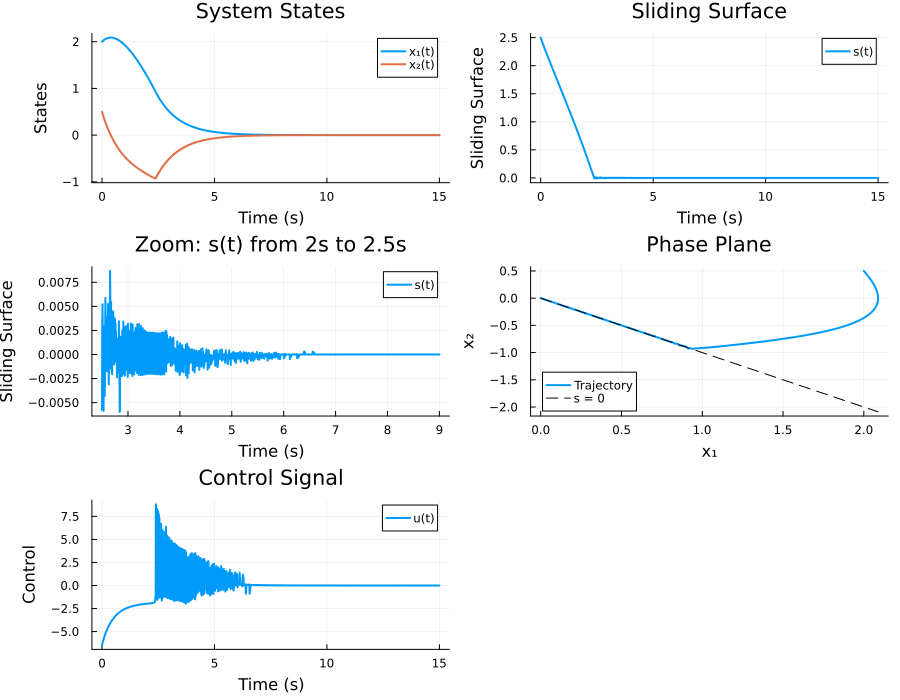

In [4]:
# Create the plots

# 1. States x1(t) and x2(t)
p1 = plot(ts, x_mat',
    label=["x₁(t)" "x₂(t)"],
    xlabel="Time (s)",
    ylabel="States",
    title="System States",
    lw=2)

# 2. Sliding surface s(t)
p2 = plot(ts, s_vals,
    label="s(t)",
    xlabel="Time (s)",
    ylabel="Sliding Surface",
    title="Sliding Surface",
    lw=2)

# Subconjunto de datos en el intervalo de interés
ts_zoom = ts[(ts .>= 2.5) .& (ts .<= 9)]
s_zoom = s_vals[(ts .>= 2.5) .& (ts .<= 9)]

# Nuevo subplot con el zoom
p2_zoom = plot(ts_zoom, s_zoom,
    label="s(t)",
    xlabel="Time (s)",
    ylabel="Sliding Surface",
    title="Zoom: s(t) from 2s to 2.5s",
    lw=2)

# 3. Phase plane with s = 0 line
x1_line = range(minimum(x1s), stop=maximum(x1s), length=100)
x2_line = -c .* x1_line
p3 = plot(x1s, x2s,
    label="Trajectory",
    xlabel="x₁",
    ylabel="x₂",
    title="Phase Plane",
    lw=2)
plot!(p3, x1_line, x2_line,
    label="s = 0",
    linestyle=:dash,
    color=:black)

# 4. Control u(t)
p4 = plot(ts, u_vals,
    label="u(t)",
    xlabel="Time (s)",
    ylabel="Control",
    title="Control Signal",
    lw=2)

# --------------------------
# Combine into a 2×2 figure
plot(p1, p2, p2_zoom, p3, p4, layout=(3,2), size=(900, 700))
# Save the figure
# savefig("../img/problem1_1.png")
# savefig("../img/problem1_2_sigmoid.png")
# savefig("../img/problem1_2_sat.png")


## Exercise 1.6
For the DC motor modeled by
$$
\begin{aligned}
J\frac{d\omega}{dt} &= k_m i - T_L \\
L\frac{d i}{dt} &= -iR -k_b \omega + u
\end{aligned}
$$
where $J$ is the moment of inertia, $i$ is the armature current, $L$ and $R$ are the armature inductance and resistance respectfully, $\omega$ is the motr angular speed, $k_b$ is a constant of back elecromotive force, $k_m$ is a motor torque constant, $T_L$ is an unknown load torque which is bounded and has bounded derivative, and $u$ is a control function defined by the armature voltage, design a sliding mode control $u$, steering the angular speed $\omega$ to zero assuming both $i$ and $\omega$ are measurable and all parameters are known. Simulate the control system with $R = 1\Omega$, $L=0.5\text{H}$, $k_m = 5\times 10^{-2} \text{Nm/A}$, $k_b = k_m$, $J = 10^{-3} \text{Nm}\text{s}^2 / \text{rad}$, $T_L = 0.1 \sin (t)$Nm, $\omega(0) = 1$rad/s, and $i(0) = 0$. Plot the time histories of the sliding variable, the control function $u$, the current $i$, and the angular speed $\omega$.

In [5]:
# Initial conditions and params
x0 = [1, 0]
tspan = [0.0, 15.0]

c = 1
rho = 0.5
R = 1
L = 0.5
km = 5e-2
kb = 5e-2
J = 10e-3

# Arreglos para almacenar s(t) y u(t)
s_vals = Float64[]
u_vals = Float64[]

# Sistema con Sliding Mode Control y logging
function system!(dx, x, p, t)
    x1, x2 = x
    T = 0.1 * sin(t)
    #s = (km/J)*x2 + c*x1 - (T/J)
    s = (km/J)*x2 + c*x1
    v = -rho * sign(s)
    u = (R - L*c)*x2 + kb*x1 + (L/km)*v
    
    dx[1] = 1/J * (km*x2 - T)
    dx[2] = 1/L * (-R*x2 - kb*x1 + u)

    # Guardar valores de s y u
    push!(s_vals, s)
    push!(u_vals, u)
end

# Problema y solución
prob = ODEProblem(system!, x0, tspan);
sol = solve(prob, Tsit5(), saveat=0.005 , maxiters=1_000_000);

In [6]:
# Procesar resultados
ts = sol.t
x_mat = hcat(sol.u...)
x1s = x_mat[1, :]
x2s = x_mat[2, :]

# Calcular superficie s(t) y control u(t)
s_vals = Float64[]
u_vals = Float64[]

for (i, t) in enumerate(ts)
    x1 = x1s[i]
    x2 = x2s[i]
    T = 0.1 * sin(t)
    #s = (km/J)*x2 + c*x1 - (T/J)
    s = (km/J)*x2 + c*x1
    v = -rho * sign(s)
    u = (R - L*c)*x2 + kb*x1 + (L/km)*v
    push!(s_vals, s)
    push!(u_vals, u)
end

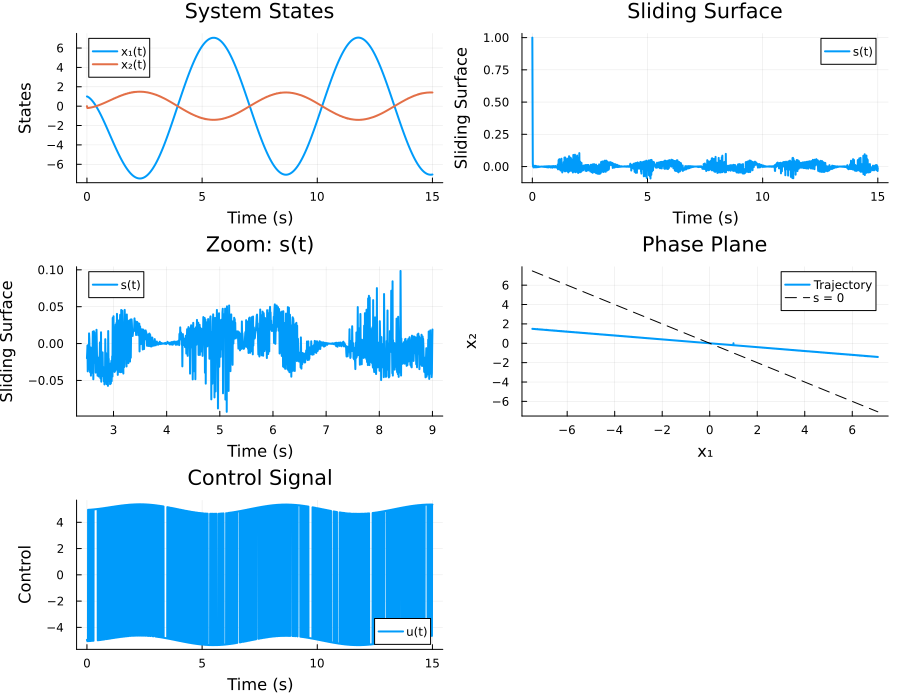

In [7]:
# Create the plots

# 1. States x1(t) and x2(t)
p1 = plot(ts, x_mat',
    label=["x₁(t)" "x₂(t)"],
    xlabel="Time (s)",
    ylabel="States",
    title="System States",
    lw=2)

# 2. Sliding surface s(t)
p2 = plot(ts, s_vals,
    label="s(t)",
    xlabel="Time (s)",
    ylabel="Sliding Surface",
    title="Sliding Surface",
    lw=2)

# Subconjunto de datos en el intervalo de interés
ts_zoom = ts[(ts .>= 2.5) .& (ts .<= 9)]
s_zoom = s_vals[(ts .>= 2.5) .& (ts .<= 9)]

# Nuevo subplot con el zoom
p2_zoom = plot(ts_zoom, s_zoom,
    label="s(t)",
    xlabel="Time (s)",
    ylabel="Sliding Surface",
    title="Zoom: s(t)",
    lw=2)

# 3. Phase plane with s = 0 line
x1_line = range(minimum(x1s), stop=maximum(x1s), length=100)
x2_line = -c .* x1_line
p3 = plot(x1s, x2s,
    label="Trajectory",
    xlabel="x₁",
    ylabel="x₂",
    title="Phase Plane",
    lw=2)
plot!(p3, x1_line, x2_line,
    label="s = 0",
    linestyle=:dash,
    color=:black)

# 4. Control u(t)
p4 = plot(ts, u_vals,
    label="u(t)",
    xlabel="Time (s)",
    ylabel="Control",
    title="Control Signal",
    lw=2)

# --------------------------
# Combine into a 2×2 figure
plot(p1, p2, p2_zoom, p3, p4, layout=(3,2), size=(900, 700))
# Save the figure
# savefig("../img/problem1_6.png")

## Exercise 1.7
Repeat Ex. 1.6 assuming that only $\omega(t)$ is measured. Design a sliding mode observer for estimating $\hat{i}(t) \rightarrow i(t)$. Simulate the control system. Plot the time histories of the sliding variable, the control function $u$, the angular speed $\omega$, the current $i$, and its estimate $\hat{i}$.

### Sol

Let the observer estimate the state $ \hat{x}_1 $ using:
$$
\dot{\hat{x}}_1 = v,
$$
and define the observation error:
$$
z_1 = \hat{x}_1 - x_1.
$$

Taking the derivative:
$$
\dot{z}_1 = \dot{\hat{x}}_1 - \dot{x}_1 = v - \left(\frac{k_m}{J}x_2 - \frac{T_L}{J}\right).
$$

Define the correction term:
$$
v = -\rho \, \text{sign}(z_1),
$$
with the gain satisfying:
$$
\rho > \frac{k_m}{J} |x_2| + \frac{|T_L|_{\max}}{J} + \beta, \quad \beta > 0.
$$

Thus:
$$
\dot{z}_1 = -\frac{k_m}{J} x_2 + \frac{T_L}{J} - \rho \, \text{sign}(z_1),
$$
and
$$
z_1 \dot{z}_1 = z_1 \left(-\frac{k_m}{J} x_2 + \frac{T_L}{J} - \rho \, \text{sign}(z_1)\right).
$$

On the sliding surface $ z_1 = 0 $, the equivalent control satisfies:
$$
\dot{z}_1 = 0 \Rightarrow -\frac{k_m}{J} x_2 + \frac{T_L}{J} + v_{\text{eq}} = 0.
$$

Solving for $ x_2 $, we get:
$$
x_2 = \frac{T_L}{k_m} + \frac{J}{k_m} v_{\text{eq}}.
$$

Since $ T_L $ is not known exactly, we estimate $ x_2 $ using only $ v_{\text{eq}} $. To approximate $ v_{\text{eq}} $, we use a **low-pass filter**:
$$
\tau \dot{\hat{v}}_{\text{eq}} = -\hat{v}_{\text{eq}} - \rho \, \text{sign}(z_1),
$$
where $ \tau $ is the filter time constant.

Thus, after the reaching time $ t_r $, we estimate:
$$
\hat{x}_2(t) \approx \frac{T_L}{k_m} + \frac{J}{k_m}\hat{v}_{\text{eq}}(t)
$$


In [8]:
# Initial conditions and params
x0 = [1.0, 0.0, 0.0, 0.0]  # [x1, x2, x̂1, v̂_eq]
tspan = [0.0, 15.0]
c = 1
rho = 0.5
R = 1
L = 0.5
km = 5e-2
kb = 5e-2
J = 10e-3
# Parámetros del observador
rho_obs = 20.0       # Ganancia del observador
tau = 0.01           # Constante de tiempo del filtro (aumentado de 0.01 a 0.1)

# IMPORTANTE: Mover las estructuras de datos fuera de la función ODE
# para mejorar el rendimiento
function system!(dx, x, p, t)
    # Estados reales
    x1, x2 = x[1], x[2]
    # Estados del observador
    x1hat = x[3]        # estimación de x1
    veq_hat = x[4]      # señal filtrada
    # Señales externas
    T = 0.1 * sin(t)
    # Estado estimado
    z1 = x1hat - x1
    v_obs = -rho_obs * sign(z1)
    # Estimación de x2 a partir de v_eq estimado
    x2hat = T / km + (J / km) * veq_hat
    # Control deslizante
    #s = (km/J)*x2 + c*x1 - (T/J)
    s = veq_hat + c*x1
    v_ctrl = -rho * sign(s)
    u = (R - L*c)*x2 + kb*x1 + (L/km)*v_ctrl
    # Dinámicas del sistema
    dx[1] = 1/J * (km*x2 - T)
    dx[2] = 1/L * (-R*x2 - kb*x1 + u)
    # Dinámicas del observador
    dx[3] = v_obs                                    # ẋ̂₁ = v_obs
    dx[4] = (-veq_hat - rho_obs * sign(z1)) / tau    # filtro de v_eq
    
    # CRÍTICO: Eliminar el logging dentro de la función ODE
    # Esto ralentiza significativamente la solución
end

prob = ODEProblem(system!, x0, tspan)
    
# Usar un paso fijo muy pequeño para manejar las discontinuidades
sol = solve(prob, Rosenbrock23(autodiff=false),
            dt=1e-4,           # Paso fijo muy pequeño
            adaptive=false,    # Desactivar adaptación
            saveat=0.01);       # Guardar solo en estos puntos

In [9]:
# Procesar resultados
ts = sol.t
x_mat = hcat(sol.u...)
x1s = x_mat[1, :]
x2s = x_mat[2, :]
x1_hat = x_mat[3, :]
veq_hat = x_mat[4, :]

# Estimación de x2 usando veq_hat
x2_hat = 0.1 .* sin.(ts) ./ km .+ (J / km) .* veq_hat

# Error de observación
e_obs = x2s .- x2_hat;

# Recalcular s_vals y u_vals alineados con ts
s_vals = Vector{Float64}(undef, length(ts))
u_vals = Vector{Float64}(undef, length(ts))

for (i, t) in enumerate(ts)
    x1 = x1s[i]
    x2 = x2s[i]
    veqhat = veq_hat[i]
    x1hat = x1_hat[i]
    x2hat = x2_hat[i]
    T = 0.1 * sin(t)
    #s = (km/J)*x2 + c*x1 - (T/J)
    s = veqhat + c*x1
    v = -rho * sign(s)
    u = (R - L*c)*x2 + kb*x1 + (L/km)*v
    s_vals[i] = s
    u_vals[i] = u
end

In [10]:
# Create the plots

# 1. States x1(t) and x2(t)
p1 = plot(ts, [x1s x2s],
    label=["x₁(t)" "x₂(t)"],
    xlabel="Time (s)",
    ylabel="States",
    title="System States",
    lw=2)

# 2. Sliding surface s(t)
p2 = plot(ts, s_vals,
    label="s(t)",
    xlabel="Time (s)",
    ylabel="Sliding Surface",
    title="Sliding Surface",
    lw=2)

# Subconjunto de datos en el intervalo de interés
ts_zoom = ts[(ts .>= 2.5) .& (ts .<= 9)]
s_zoom = s_vals[(ts .>= 2.5) .& (ts .<= 9)]

# Nuevo subplot con el zoom
p2_zoom = plot(ts_zoom, s_zoom,
    label="s(t)",
    xlabel="Time (s)",
    ylabel="Sliding Surface",
    title="Zoom: s(t)",
    lw=2)

# 3. Phase plane with s = 0 line
x1_line = range(minimum(x1s), stop=maximum(x1s), length=100)
x2_line = -c .* x1_line
p3 = plot(x1s, x2s,
    label="Trajectory",
    xlabel="x₁",
    ylabel="x₂",
    title="Phase Plane",
    lw=2)
plot!(p3, x1_line, x2_line,
    label="s = 0",
    linestyle=:dash,
    color=:black)

# 4. Control u(t)
p4 = plot(ts, u_vals,
    label="u(t)",
    xlabel="Time (s)",
    ylabel="Control",
    title="Control Signal",
    lw=2)

p5 = plot(ts, x2s,
    label="x₂(t) (real)",
    xlabel="Time (s)",
    ylabel="x₂",
    title="Comparison: x₂ vs x̂₂",
    lw=2)
plot!(p5, ts, x2_hat,
    label="x̂₂(t) (estimated)",
    linestyle=:dash,
    lw=2)

p6 = plot(ts, e_obs,
    label="e(t) = x₂ - x̂₂",
    xlabel="Time (s)",
    ylabel="Estimation Error",
    title="Observation Error",
    lw=2)

# Combina todos los plots
plot(p1, p2, p2_zoom, p3, p4, p5, p6, layout=(4,2), size=(950, 800))

# Save
savefig("../img/problem1_7.png")

"/home/aleon/Documents/maestria_2sem/SlidingModes/tarea1/img/problem1_7.png"